# 1.Spatially constrained clustering (SCC) with binnning data

This notebook demonstrates how to perform basic clustering on a raw anndata object (spatial transcriptomic data) 
using spateo and SCC clustering.

Binning anndata object can be obtained with spateo.io functions from multiple spatial transcriptomic assays. 
(See the docs for spateo.io)

## Packages

In [1]:
import spateo as st
import dynamo as dyn

2024-10-10 01:53:06.473540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 01:53:06.486583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 01:53:06.490618: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 01:53:07.155864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


alphashape is not installed. Please install it using 'pip install alphashape'.
fastpd is not installed. If you need mesh correction, please compile the fastpd library.


## Data source
**bin60_h5ad:** https://www.dropbox.com/s/c5tu4drxda01m0u/mousebrain_bin60.h5ad?dl=0


In [2]:
# Load binning data
fname_bin60 = "mousebrain_bin60.h5ad"
adata_bin60 = st.sample_data.mousebrain(fname_bin60)
adata_bin60

|-----> Downloading data to ./data/mousebrain_bin60.h5ad


AnnData object with n_obs × n_vars = 7765 × 25691
    obs: 'area', 'n_counts'
    uns: '__type', 'pp', 'spatial'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial'
    layers: 'count', 'spliced', 'unspliced'

## Normalization & Dimensional reduction

In [3]:
# Preprocessing
st.pp.filter.filter_genes(adata_bin60, min_cells=3, inplace=True)

# Normalization
dyn.pp.normalize_cell_expr_by_size_factors(adata_bin60, layers="X")

# Linear reduction
st.tl.pca_spateo(adata_bin60, n_pca_components=30)

# Identify neighbors(KNN)
dyn.tl.neighbors(adata_bin60, n_neighbors=30)

|-----> Set <adata.X> to normalized data


/tmp/ipykernel_2130075/3851410998.py:5: DeprecationWarning:

normalize_cell_expr_by_size_factors is deprecated and will be removed in a future release. Please update your code to use the new replacement function.



|-----> Running PCA on adata.X...
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method pynn selected


AnnData object with n_obs × n_vars = 7765 × 21667
    obs: 'area', 'n_counts', 'Size_Factor', 'initial_cell_size'
    var: 'pass_basic_filter'
    uns: '__type', 'pp', 'spatial', 'neighbors'
    obsm: 'X_spatial', 'bbox', 'contour', 'spatial', 'X_pca'
    layers: 'count', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

## Vanilla louvain clustering

|-----> accessing adj_matrix_key=connectivities built from args for clustering...
|-----> Detecting communities on graph...
|-----------> Converting graph_sparse_matrix to igraph object
|-----? louvain is not maintained, we recommend using leiden instead.
|-----> [Community clustering with louvain] completed [1.5006s]


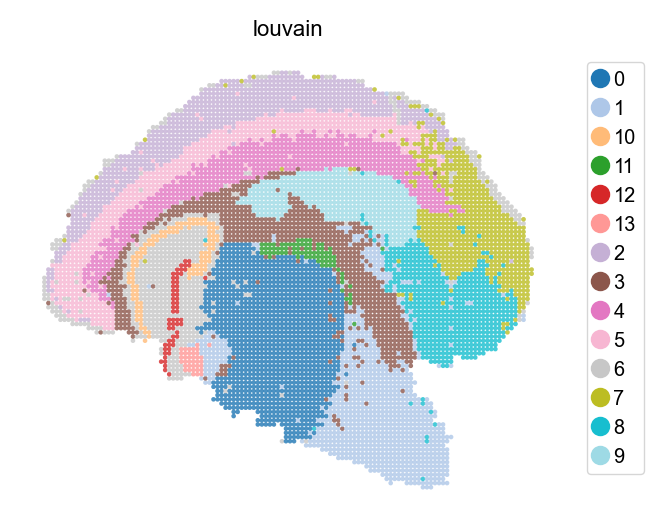

In [3]:
#louvain clustering
dyn.tl.louvain(adata_bin60, resolution=1)
st.pl.space(adata_bin60, color=['louvain'], show_legend="upper left", 
            figsize=(4, 3), color_key_cmap="tab20")


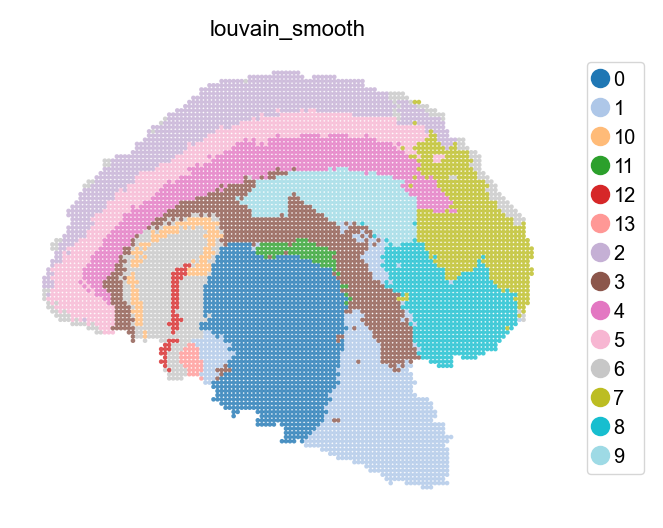

In [4]:
adata_bin60.obs['louvain_smooth']=st.tl.smooth(adata_bin60, radius=5, key='louvain')
st.pl.space(adata_bin60, color=['louvain_smooth'], show_legend="upper left", 
            figsize=(4, 3), color_key_cmap="tab20")

## Spatially constrained clustering (SCC)

The SCC clustering function is implemented based on basic clustering methods (e.g. louvain, leiden, ...), 
by replacing the input K-nearest neighbor(KNN) network, with the fusion of KNN and spatial neighbor network.

We adjust the computational weight of spatial nearness by adjusting the s_neigh argument. Typically, we set 
s_neigh according to the spatial arrangement of spots (i.e. the assay we use). For example, s_neigh could 
be 4, 8, 12, etc, in a squared array sequencing platform (such as Stereo-seq, ...), and could be 6, 18, etc, 
in a hexagon platform (such as Visium, ...). Larger s_neigh brings larger weight for spatial information, while 
we do not recommend setting s_neigh too big.


|-----> <insert> expression_connectivities to obsp in AnnData Object.
|-----> <insert> expression_distances to obsp in AnnData Object.
|-----> <insert> expression_neighbors to uns in AnnData Object.
|-----> <insert> expression_neighbors.indices to uns in AnnData Object.
|-----> <insert> expression_neighbors.params to uns in AnnData Object.
|-----> <insert> spatial_distances to obsp in AnnData Object.
|-----> <insert> spatial_connectivities to obsp in AnnData Object.
|-----> <insert> spatial_neighbors to uns in AnnData Object.
|-----> <insert> spatial_neighbors.indices to uns in AnnData Object.
|-----> <insert> spatial_neighbors.params to uns in AnnData Object.
|-----> using adj_matrix from arg for clustering...
|-----------> Converting graph_sparse_matrix to igraph object
|-----> [Community clustering with louvain] in progress: 100.0000%
|-----> [Community clustering with louvain] finished [9.8030s]


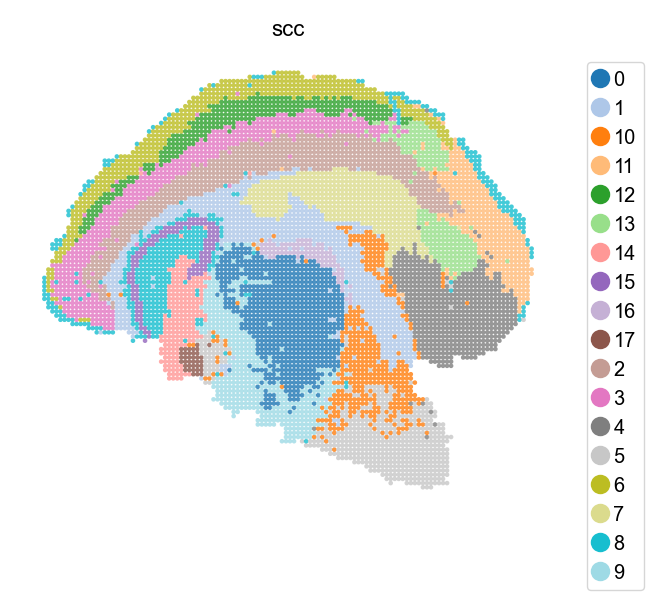

In [6]:
#scc clustering
st.tl.scc(
    adata_bin60,
    s_neigh=8,
    e_neigh=30,
    resolution=2,
    cluster_method="louvain",
    key_added="scc",
    pca_key="pca",
)
st.pl.space(adata_bin60, color=['scc'], show_legend="upper left", 
            figsize=(4, 3), color_key_cmap="tab20")

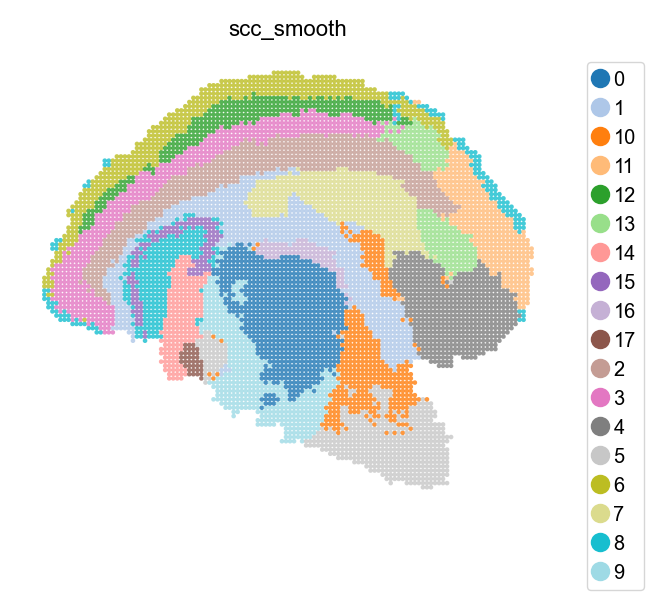

In [8]:
adata_bin60.obs['scc_smooth']=st.tl.smooth(adata_bin60, radius=5, key='scc')
st.pl.space(adata_bin60, color=['scc_smooth'], show_legend="upper left", 
            figsize=(4, 3), color_key_cmap="tab20")

## SCC clusters annotation

In [6]:
domain_annotations = [
    "Isocortex L6",
    "Fiber tracts",
    "CTXsp",
    "PAL",
    "Isocortex L4",
    "OLF",
    "DG",
    "CA",
    "RT",
    "VS",
    "DORpm",
    "AMY",
    "Isocortex L5",
    "HY",
    "DORsm",
    "HIP & CTXpl L1",
    "Isocortex L2/3",
    "STRd",
]

adata_bin60.obs['scc_anno'] = adata_bin60.obs['scc'].copy()
adata_bin60.rename_categories('scc_anno', domain_annotations)

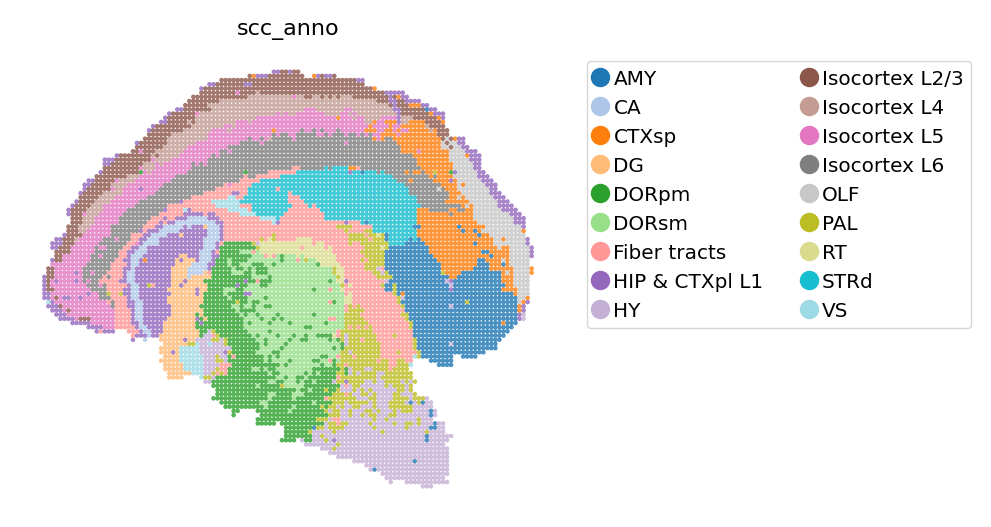

In [7]:
st.pl.space(
    adata_bin60,
    color=['scc_anno'],
    show_legend="upper left",
    figsize=(4, 3),
    color_key_cmap="tab20"
)

In [8]:
adata_bin60.write("mousebrain_bin60_clustered.h5ad", compression="gzip")